In [1]:
import html
import os
import textwrap

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datasets import load_dataset, load_from_disk
from IPython.display import Markdown, display
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)

In [2]:
# Глобальные переменные
rstate = 42

# 1. Подготовка данных и модели

Token indices sequence length is longer than the specified maximum sequence length for this model (2056 > 2048). Running this sequence through the model will result in indexing errors


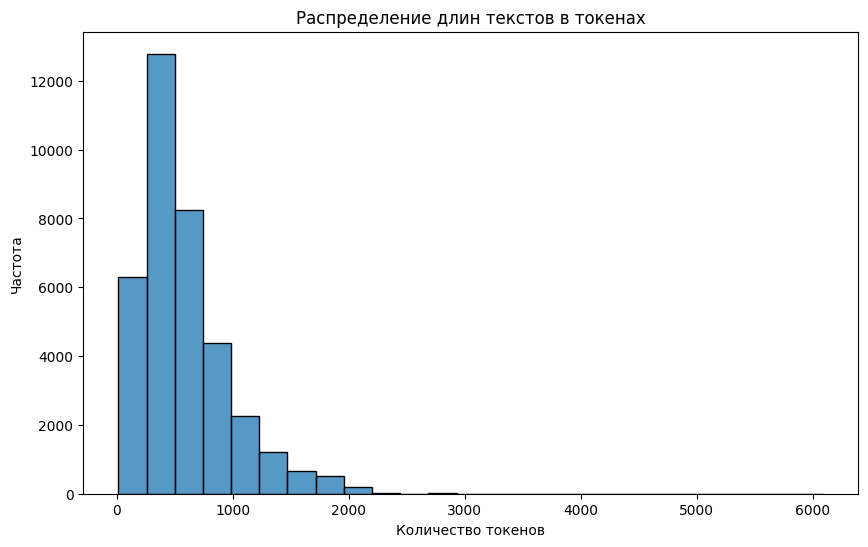

In [3]:
# 1.1. Выбор и загрузка датасета
# Используем датасет с отзывами на фильмы с Кинопоиска
dataset_name = "blinoff/kinopoisk"
local_dataset_path = "./kinopoisk_dataset_local"

# Скачиваем датасет, если локальная копия отсутствует
if os.path.exists(local_dataset_path):
    dataset = load_from_disk(local_dataset_path)
else:
    dataset = load_dataset(dataset_name)
    dataset.save_to_disk(local_dataset_path)

# 1.2. Выбор и загрузка предобученной модели и токенизатора
model_name = "ai-forever/rugpt3small_based_on_gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Добавляем специальный токен для padding, если он отсутствует
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": tokenizer.eos_token})
    model.resize_token_embeddings(len(tokenizer))

# 1.3. Предварительная обработка данных
train_split = dataset["train"]

# Определение оптимальной длины контекста. Посмотрим на распределение длин текстов.
text_lengths = [len(tokenizer.encode(html.unescape(text))) for text in train_split["content"]]
plt.figure(figsize=(10, 6))
sns.histplot(text_lengths, bins=25)
plt.title("Распределение длин текстов в токенах")
plt.xlabel("Количество токенов")
plt.ylabel("Частота")
plt.show()

In [4]:
# Исходя из распределения токенов по датасету выберем контекст
# покрывающий больше 50% данных
context_length = 512


# Функция для токенизации
def tokenize_function(examples):
    return tokenizer(
        html.unescape(examples["content"]), padding="max_length", truncation=True, max_length=context_length
    )


# Применяем токенизацию
tokenized_dataset = train_split.map(
    tokenize_function,
    batched=True,
    remove_columns=train_split.column_names,  # Удаляем все старые колонки
)

print("\nСтруктура токенизированного датасета:")
print(tokenized_dataset)

# Создаем train/validation сплит вручную
train_val_split = tokenized_dataset.train_test_split(test_size=0.1, seed=rstate)
train_dataset = train_val_split["train"]
val_dataset = train_val_split["test"]

print(f"\nРазмер обучающей выборки: {len(train_dataset)}")
print(f"Размер валидационной выборки: {len(val_dataset)}")

# Генератор батчей для обучения
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)


Структура токенизированного датасета:
Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 36591
})

Размер обучающей выборки: 32931
Размер валидационной выборки: 3660


## 2. Дообучение модели

### 2.1. Предварительная оценка качества

In [5]:
# Переносим на GPU, если доступно
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Генерируем текст
print("--- Результат генерации ДО дообучения: ---\n")

prompt = "Этот фильм был просто "
print(f"1. Промт: {prompt}\n")
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
output = model.generate(input_ids, max_length=50, num_return_sequences=1, no_repeat_ngram_size=2)
print(tokenizer.decode(output[0], skip_special_tokens=True))

prompt = "2+2+?"
print(f"\n2. Промт: {prompt}\n")
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
output = model.generate(input_ids, max_length=50, num_return_sequences=1, no_repeat_ngram_size=2)
print(tokenizer.decode(output[0], skip_special_tokens=True))

--- Результат генерации ДО дообучения: ---

1. Промт: Этот фильм был просто 

Этот фильм был просто 
&quot;Сумерки&nbsp;Фантазии&raquo; (1968).

В фильме снимались:
-&laquoslash;&mdash;&nbsp;&

2. Промт: 2+2+?

2+2+?

Какие есть способы, чтобы не было проблем с интернетом? Как можно быстрее? Спасибо!
В настройках браузера.
в настройке браузеров
У меня тоже самое, только в настройками брауз


### 2.2. Настройка процесса обучения

In [6]:
# Отключаем внутреннюю многопоточность токенизатора
# Многопоточность будет обеспечена на уровне DataLoader, а не токенизатора.
# Одновременное использование fork (от DataLoader) и threads (от Rust-токенизатора) вызывает deadlocks.
os.environ["TOKENIZERS_PARALLELISM"] = "false"

training_args = TrainingArguments(
    output_dir="./kinopoisk_generator",
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=3,
    load_best_model_at_end=True,
    learning_rate=2e-5,
    num_train_epochs=5,
    fp16=True,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    dataloader_num_workers=4,
    logging_dir="./logs",
    logging_steps=100,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=tokenizer,
    data_collator=data_collator,
)

print("Начинаем дообучение модели...")
trainer.train()
print("Дообучение завершено.")

Начинаем дообучение модели...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

Средняя утилизация GPU по логам `nvidia-smi --query-gpu=timestamp,utilization.gpu --format=csv -l 1 -f "gpu_log.csv"` за все время обучения:

**97.67%**

Оптимизация процесса обучения приемлемая, батчи формируются и подаются оптимально.

In [ ]:
# Путь к папке с лучшим чекпоинтом
best_ckpt_path = trainer.state.best_model_checkpoint

# Значение функции потерь на валидационной выборке
best_metric_value = trainer.state.best_metric

print(f"Лучшая модель была загружена из: {best_ckpt_path}")
print(f"Лучший validation loss: {best_metric_value}")

Лучшая модель была загружена из: ./kinopoisk_generator/checkpoint-10000
Лучший validation loss: 2.6127145290374756


### 2.3. Оценка качества обучения

In [ ]:
# Используем тот же промпт для сравнения
# trainer.model уже находится на нужном устройстве после обучения
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(trainer.model.device)

# Генерируем текст с помощью дообученной модели
output_after = trainer.model.generate(input_ids, max_length=50, num_return_sequences=1, no_repeat_ngram_size=2)

print("Результат генерации ПОСЛЕ дообучения:")
print(tokenizer.decode(output_after[0], skip_special_tokens=True))

Результат генерации ПОСЛЕ дообучения:
Этот фильм был просто  «нарисован» на экране.

Сюжет. Фильм, который я не могу назвать шедевром. Он просто не может не…
На мой взгляд, это


# 3. Сэмплирование

In [ ]:
def run_generation_test(prompt_text, generation_params):
    # Используем устройство, на котором уже лежит модель
    device = trainer.model.device

    # Локальная копия для защиты от изменения глобальной переменной generation_params
    local_params = generation_params.copy()

    # Токенизация промта и передача его на устройство с моделью
    inputs = tokenizer(prompt_text, return_tensors="pt").to(device)

    if "pad_token_id" not in local_params:
        local_params["pad_token_id"] = tokenizer.eos_token_id

    # Запускаем генерацию вывода с ограничем в 400 генерируемых токенов
    output = trainer.model.generate(**inputs, max_new_tokens=400, **local_params)

    # Декодирование выхода модели
    decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)

    # Форматирование вывода для улучшения читаемости в ноутбуке
    decoded_output = html.unescape(decoded_output)
    cleaned_text = " ".join(decoded_output.split())
    wrapped_text = textwrap.fill(cleaned_text, width=100)

    # Вывод параметров и форматированного вывода модели
    title = f"--- ПАРАМЕТРЫ: {local_params} ---"
    markdown_output = f"**{title}**\n\n```\n{wrapped_text}\n```"
    display(Markdown(markdown_output))

In [ ]:
sampling_prompt = "Кино вышло что надо. Особенно понравился"

#### 1. Greedy decoding

In [ ]:
run_generation_test(sampling_prompt, {"do_sample": False})

**--- ПАРАМЕТРЫ: {'do_sample': False, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился момент, когда герой, который не был в списке, но был в
списке, говорит, что он не был в списке. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет.
Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет.
Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет.
Сюжет. Сюжет. Сюжет. Сюжет.
```

**Вывод:** ожидаемо генерирует повторяющиеся фразы.

#### 2. Beam search

In [ ]:
run_generation_test(sampling_prompt, {"num_beams": 2, "early_stopping": True})
run_generation_test(sampling_prompt, {"num_beams": 5, "early_stopping": True})

**--- ПАРАМЕТРЫ: {'num_beams': 2, 'early_stopping': True, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился момент, когда главный герой в погоне за своей мечтой, но не
тут то было. Сюжет. Спецэффекты. Спецэффекты в этом фильме были на высоте. Спецэффекты в этом фильме
были на высоте. Спецэффекты в этом фильме были на высоте. Спецэффекты в этом фильме были на высоте.
Спецэффекты в этом фильме были на высоте. Спецэффекты в этом фильме были на высоте. Спецэффекты в
этом фильме были на высоте. Спецэффекты в этом фильме были на высоте. Спецэффекты в этом фильме были
на высоте. Спецэффекты в этом фильме были на высоте. Спецэффекты в этом фильме были на высоте.
Спецэффекты в этом фильме были на высоте. Спецэффекты в этом фильме были на высоте. Спецэффекты в
этом фильме были на высоте. Спецэффекты в этом фильме были на высоте. Спецэффекты в этом фильме были
на высоте. Спецэффекты в этом фильме были на высоте. Спецэффекты в этом фильме были на
```

**--- ПАРАМЕТРЫ: {'num_beams': 5, 'early_stopping': True, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился сюжет. Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет:
Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет:
Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет:
Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет: Сюжет:
```

**Вывод:** Генерирует связные, но все еще повторяющиеся фразы.

#### 3. Temperature sampling

In [ ]:
run_generation_test(sampling_prompt, {"do_sample": True, "temperature": 0.7})
run_generation_test(sampling_prompt, {"do_sample": True, "temperature": 1.2})

**--- ПАРАМЕТРЫ: {'do_sample': True, 'temperature': 0.7, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился сюжет. К примеру, в каком-то фильме по неписаным законам
жанра, что не может не восхищать. Фильм снят на свежие деньги, актеры подобраны на ура — все
отлично. Сюжет фильма не претендует на откровенный юмор, он просто заставляет задуматься над многими
вещами. Актерская игра. От меня только слова восхищения. Джон Рис для меня стал одним из лучших
актеров. Он влюбил в себя всех героев. Я не буду писать все слова, ибо это не важно. Режиссер. Я
вообще не представляю себе актеров, которые бы взяли на себя роль Джека Воробья. Они просто идеально
вписались в свой образ. Я не влюблена в Джонни Деппа, но в фильме «Престиж» он снял отличный образ.
Музыка. Музыка в фильме очень хорошая. Она отлично передает атмосферу фильма, а потом, добавляет ее
в фильм. Актеры. Мне понравилась игра всех актеров. Джон Пирс, Марк Уолберг, Рэй Пенн и другие. Я
очень люблю Джона, и поэтому могу сказать, что он замечательный актер. Сюжет. В фильме
рассказывается о Бэтмене, его отце, который стал для него настоящим отцом. Сюжет. Я не знаю, что
можно добавить к этому, но я не могу сказать, что это фильм плохой. Фильм хорош. Сюжет. Я думаю, что
он один из лучших фильмов, которые я смот
```

**--- ПАРАМЕТРЫ: {'do_sample': True, 'temperature': 1.2, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился момент с проходном, где все персонажи просто сходились «в
одно целое для разницы восприятия». Этот момент заслуживает внимания. Да, фильм сильно отличается от
такой версии сценария, но в нем нет лишних диалогов, диалогов которые не теряют своей
«выпутанности». Нет эмоций, когда они могли не сказать пару слов, или сказать какой какой то наряду
эпизодов, концовка тоже удивляет, просто от этого места не треснула ни одна сюжетная линия. Конечно,
меня не побоязали воспринимать творчество Спилберга серьёзно, но и не понимали его книг и
перечислить некоторые факты из него не получаются, а я в этом, наверное, виновата перед создателями,
не заплатила им деньги вперед. А в итоге, у моего просмотра было такое недоумение, что это кино
снято под названием «кино, без которого жизнь будет не только скучной, но так же бездушной и бедно
бессмысленной». Я, конечно, понимаю почему этот продукт так многообещающ, но на деле… Все его
попытки сделать кино хуже своих предшественников не вдохновили что-то. Фильм можно было бы приложить
и к режиссеру который делал фильм о нашествии, и к сценаристам от него, или может кого-нибудь к тем
людям, кто работал над «Идеальным фильмом». Но получается получилось то как. Возможно я ждал
«Дневного дозора» (хоть он и был не нова), как и многие ждал. Но мне казалось, «Идеальное кино».
Фильм снят на уровне, возможно
```

**Вывод**: добавление случайности радикально решило проблему повторяющихся фраз. С увеличением температуры они пропадают вовсе. Но теперь, модель не генериует `EOS` токен, генерация обрывается на пределе генерируемых токенов. 

#### 4. Top-p (nucleus) sampling, Top-k Sampling

In [ ]:
run_generation_test(sampling_prompt, {"do_sample": True, "top_p": 0.92, "top_k": 0})
run_generation_test(sampling_prompt, {"do_sample": True, "top_k": 50})

**--- ПАРАМЕТРЫ: {'do_sample': True, 'top_p': 0.92, 'top_k': 0, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился маньяк. Посмотреть на его гневную и необычную кривляку всем
очень рекомендую, а так же еще и не один раз. Он практически холодный, как говорят, «огромный». И
ещё ужаснейшее падение на подоконнике и на креслах — где будет видетьсь твоя голова, если тебя так
грохочут. Сюжетная линия очень сильная, да еще и логичная. Есть стойкое ощущение, что они уже давно
разыграли этот спектакль. То есть слишком тупо как-то стало. Насчёт того, что в городе не бывает
чудо-сюрреализма, тут что-то не так. Ну и непонятно что дальше мы получаем, когда ТАМ происходит
убийство полицией пешехода. Интересно, где девушка в должном возрасте разбирается с водительским
нагоном? А вот тут жаль, но нужно понимать, что убийство сына полицейского просто ненужно.
Единственный, кто развернулся так сразу — это сам Питт, который вроде так и уже уже успел настолько
надоесть, что только воспоминание о нем могло перерасти в массовый протест. Наверно поэтому он и
остается таким тупым до последнего. Актерскую игру я показать не могу, только по книге. Местами было
просто дико. Хочу отметить саундтрек, а то мы уже полтора года не видим сеем трагедию. Не верите?
Итог. Иногда полезно посмотреть на жизнь сквозь призму телевизора и плеяний. Главное не быть
бессердечным крикуном и думать о заслуживании.
```

**--- ПАРАМЕТРЫ: {'do_sample': True, 'top_k': 50, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился сюжет, что, так сказать, на любителя Голливуда фильм не
смотреть. Мне как зрителю было трудно оторваться от экрана, когда стало ясно, кто играет. Но все же,
по сути «Крестный отец» — это шедевр с большой буквы, поэтому я бы его оценял только с другой
стороны, а если так, то заявление поставить мне и поставить 3 балли Я в принципе понимаю. Главный
минус в этом фильме — это актерская игра. Актерский состав у Нила это уже давно зарекомендовал себя,
а сцены, где главный герой с рыжей собакой, я бы назвал, «круглосуточно» подходят для этого фильма.
Все снимали исключительно на зловредную книгу, да и не хотели делать эту книгу для «злых дядек».
Сюжет, как бывают в любом произведении, предсказуем, но есть такие актеры, которых надо уважать. У
Кинга не хватило актерского таланта на этот фильм, а то, что он взял все игру, и посетил «Крестного
отца», и то что он играл и произвел впечатление на меня и мое окружение и так получилось, что он
показал, на мой взгляд, лучший фильм с ролью Крестного отца. Ну не только тот фильм заставил меня
задуматься. Кинопоиска сейчас много, даже много, и не только у нас, но и в Западном кино (например),
то что я знаю и посмотрел этот фильм уже давно. И фильм понравился, как и многие рецензии на этот
фильм. Но
```

**Вывод:** практически получился связный текст. По сути оба метода выбора следующего токена решают одинаковую задачу - выводы очень похожи. 

#### 6. Min-p Sampling

In [ ]:
run_generation_test(
    sampling_prompt,
    {
        "do_sample": True,
        "min_p": 0.05,
        "pad_token_id": tokenizer.eos_token_id,
    },
)

**--- ПАРАМЕТРЫ: {'do_sample': True, 'min_p': 0.05, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился эпизод с ним, где он в отчаянии говорит, как ему больно и
нужно бороться и конечно же настолько много положительных эмоций. Итог. Фильм, как и многие картины,
о силе веры и веры, о силе любви. И так как первое, что приводит в восторг это первый фильм с
участием Боба Дауни-младшего. В нём всё настолько интересно и весело, что не хочется даже смотреть
фильм. В нём нет ни одной фальшивой фразы, всё настолько естественно, что кажется, что фильм будто
специально придуман, чтобы ты снова переживаешь и сопереживаешь за героя. Фильм просто шедевр. Даже
не думаю что есть люди, которые его не смотрели, а все помнят его всемирными и местными
кинофестивалями. Мне было очень приятно увидеть его впервые. Как раз в год, когда идёт —
пересматриваешь, переживаешь за героя. А в середине фильма я был просто в восторге, потому что не
ожидал, что фильм может быть столь прекрасен и интересным. Отдельно хотелось бы отметить игру Хита
Леджера. Мне очень нравится его игровой состав. И у него было всё — и актёрская игра, и сюжетная
линия. В целом он сделал очень хороший фильм. Особенно хочется отметить сцену, где он сказал «Ты
знаешь что я умираю!» и его последние слова — «Нет, я не умираю». К тому же сцена с женой-инвалидом
из
```

### 3.2. Комбинации параметров сэмплирования

#### Комбинация 1: Высокая температура + Top-k

In [ ]:
run_generation_test(sampling_prompt, {"do_sample": True, "temperature": 1.2, "top_k": 50})

**--- ПАРАМЕТРЫ: {'do_sample': True, 'temperature': 1.2, 'top_k': 50, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился саундтрек, его жеж — не может не раскрытить эту подачу и
такое вот кино, что ж и благодаря этому можно было просто посмотреть не досмотрев! Я просто обожаю
Хита и мне безумно нравится его работа во всех моментах. А что вообще такого, что он играет
человека, который не начитался отзывов на подобное произведение? Да и конечно же главный злодей и
невероятно потрясающий, на главного персонажа фильм не зря же указан. Вот кто действительно
впечатляет, так это мистер Кролик, его сыгравший — как по мне так неплохо, но к сожалению из-за
этого образ он мало запоминается. Отдельный вопрос к Климу Куценко: почему я, как это сказал
Куценко, должен пропустить какую-нибудь свою картину? Почему в каждом моем отзыве так много
положительного и интересного, на главного героя врезаются отзывы. Ну во-первых он всегда вживался в
роль суперского, профессионального, психопата, умеющего любить все, но все равно ничего не испытал с
самого начала. А вот я ждал чего-то нового и непринужданного, ничего хорошего, но не было того и
половина его фильмов. Даже если подумать, он полностью вписался в роль главного злодея. Так что это
его отличительная черта. Но самое главное из-за чего меня поразило в чем он так органически вошел,
так это его героизм. В каждом кадре присутствует много отрицательного и наме
```

**Вывод**: ожидался, креативный разнообразный текст с высокой связностью. Ожидание оправдалось.

#### Комбинация 2: Низкая температура + Top-p (Nucleus)
Идея: сгенерировать очень сфокусированный и предсказуемый текст. Низкая температура делает вероятности более 'острыми', а top-p отсекает маловероятные токены, что усиливает эффект.

In [ ]:
run_generation_test(sampling_prompt, {"do_sample": True, "temperature": 0.7, "top_p": 0.9})

**--- ПАРАМЕТРЫ: {'do_sample': True, 'temperature': 0.7, 'top_p': 0.9, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился фильм, который заставил меня влюбиться в героев. Сюжет
очень интересный, но не такой, каким его представлял в первую очередь Майкл Джей Фокс. Он был очень
разносторонним человеком. Его герой был очень умным, и сильно любил свою жену, которая не сильно
любила его. Но когда она была беременна, он сделал все, чтобы она не узнала о его существовании. Это
было так же необычно, как его отношение к женщинам. Он не знал, что он любит, но в то же время он
хотел быть с ней. Сюжет очень сильный, но не такой, как в первом фильме. В нем есть много загадок,
но они не заставляют задуматься. Актерская игра очень понравилась. Все актеры очень хорошо играли. В
фильме нет ни одной лишней сцены, которая могла бы зацепить. Музыка в фильме очень хорошая, но не
такая, как в первой части. В фильме она очень хорошая, и не так, как в первой части. Кино очень
интересное и очень интересное. Я бы сказала, что это один из самых лучших фильмов, которые я
смотрела. Мне кажется, что это один из лучших фильмов, которые я смотрела. Я смотрела его не один
раз, и я не могу назвать его шедевром. Я смотрела его снова и снова, и я никогда не соглашусь с тем,
что этот фильм гениален. Я не могу сказать, что этот фильм гениален, но я думаю, что он гениален.
Это
```

**Вывод**: ожидался, текст с меньшей креативностью по сравнению с предыдущим. Ожидание оправдалось.

#### Комбинация 3: Beam Search + Запрет повторов n-грамм
Идея: получить гладкий и связный текст (за счет `num_beams`), но принудительно запретить модели повторять одни и те же пары слов (`no_repeat_ngram_size=2`). Это часто спасает от зацикливаний.

In [ ]:
run_generation_test(sampling_prompt, {"num_beams": 5, "no_repeat_ngram_size": 2, "early_stopping": True})

**--- ПАРАМЕТРЫ: {'num_beams': 5, 'no_repeat_ngram_size': 2, 'early_stopping': True, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился момент, в котором главный герой говорит, что он не боится
смерти, а что он не боится смерти. Сюжет фильма очень интересный и захватывает с первых минут. В
первую очередь это отличный актерский состав. Леонардо ДиКаприо, как всегда, на высоте. Его герой
очень харизматичен, но его персонаж мне понравился больше, чем Роберт Дауни мл. Стивен Спейси. Он
сыграл просто потрясающе, его герою веришь. Музыка, которая была написана к фильму, просто
великолепна. Она прекрасно передает атмосферу того времени. Музыка, написанная композитором Хансом
Циммером, очень точно передает все чувства, которые были показаны зрителю во всех сценах фильма. Это
очень хороший прием, который очень хорошо передает настроение фильма, когда зритель видит, где
происходит что-то очень важное. Так же очень понравился саундтрек. Очень хорошо подобрана музыка,
которую написал композитор Хансу фон Тирсен. Все музыки были подобраны очень качественно, так как
они были написаны специально для этой картины. И конечно же сам фильм очень динамичный, поэтому я бы
хотел, чтобы вы посмотрели этот фильм еще раз. Я думаю, вам будет очень интересно, ведь фильм снят
по романтической истории любви. Романтическая история о любви, любви, дружбе, верности, преданности.
Этот фильм стоит посмотреть всем, кто любит мелодрамы, драмы, боевика. А также тем, у кого есть
свободное время, фильм понравится всем без исключения. Приятного просмотра, друзья! Приятных Вам
просмотров! Спасибо за то,
```

**Вывод:** только за счет запрета повторов ожидалось получить связный текст. Ожидание оправдалось. Но повторений все равно очень много, теперь они просто составлены из синонимов.

#### Комбинация 4: Top-k + Top-p
Идея: использовать оба метода фильтрации. Сначала отбираются `k` самых вероятных токенов, а затем из них выбираются те, что попадают в `p` вероятностной массы. Это дает очень сбалансированный и качественный результат.

In [ ]:
run_generation_test(sampling_prompt, {"do_sample": True, "top_k": 50, "top_p": 0.92})

**--- ПАРАМЕТРЫ: {'do_sample': True, 'top_k': 50, 'top_p': 0.92, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился эпизод в городе который я бы назвала «Списка Шиндлера».
Когда я согласилась посмотреть этот фильм, мне было страшно, я влюбилась в Джона Коффиса. Я не
представляю как ему не понравилась роль Джокера, его приключения и его поведение, это всё на первый
взгляд выглядит довольно нелепо, но я не стала слушать эту трясину. Так вот я согласилась с тем, что
Джокер, это самый плохой человек в жизни, которого я читала. Джокер, это тот человек, который не
может ничего сделать. Джокер, он порох, он выложился перед зрителем, он стал добрее и преступностью.
Я считаю его героя, злодеем. Джокер, этот человек не мог просто так убить кого-нибудь, он не боялся
никого, он хотел, чтобы его убили, просто чтобы его убрали. Но если его показали в кино, то я так и
не поняла. Он был злодеем? Джокер — это Джокер. Он гримёр? Джокер? Нет, Джокер, это тот человек,
которого я думаю, ему было бы нечего делать. А уж тем более Джокер, который хотел, чтобы его убрали
из жизни. Это не герой-герой. Это человек который хотел мести Джокера. Я считаю что этот фильм
достоин того, чтобы его посмотрели. Но я думаю, что сейчас нужно не выдумывать какие-то свои идеи. Я
просто хочу
```

**Вывод:** ожидалось получить золотую середину из методов фильтрации. Текст получился очень связный, но креативность пострадала.

#### EXTRA:

In [ ]:
extra_prompt = "2+2=?"
run_generation_test(extra_prompt, {"do_sample": False})

**--- ПАРАМЕТРЫ: {'do_sample': False, 'pad_token_id': 2} ---**

```
2+2=? В фильме есть и несколько ляпов, которые не всегда заметны, но всё равно, они не мешают
просмотру. 1) В фильме нет ни одного лишнего кадра, ни одного лишнего кадра. 2) В фильме нет ни
одного лишнего кадра, ни одного лишнего кадра. 3) В фильме нет ни одного лишнего кадра, ни одного
лишнего кадра. 4) В фильме нет ни одного лишнего кадра, ни одного лишнего кадра. 5) В фильме нет ни
одного лишнего кадра, ни одного лишнего кадра. 6) В фильме нет ни одного лишнего кадра, ни одного
лишнего кадра. 7) В фильме нет ни одного лишнего кадра, ни одного лишнего кадра. 8) В фильме нет ни
одного лишнего кадра, ни одного лишнего кадра. 9) В фильме нет ни одного лишнего кадра, ни одного
лишнего кадра. 10) В фильме нет ни одного лишнего кадра, ни одного лишнего кадра. 11) В фильме нет
ни одного лишнего кадра, ниодного лишнего кадра. 12) В фильме нет ни одного лишнего кадра, ниодного
лишнего кадра. 13) В фильме нет ни одного лишнего кадра, ни одного лишнего кадра. 14) В фильме нет
ни одного лишнего кадра, ни одного лишнего кадра.
```

**Оценка:** модель ожидаемо пытается превратить любой текст в отзыв.

In [ ]:
extra_prompt = (
    "Скалярная величина, которая характеризует ориентированное «растяжение» или «сжатие» многомерного евклидова"
)
run_generation_test(extra_prompt, {"do_sample": False})

**--- ПАРАМЕТРЫ: {'do_sample': False, 'pad_token_id': 2} ---**

```
Скалярная величина, которая характеризует ориентированное «растяжение» или «сжатие» многомерного
евклидова пространства. Сюжет фильма, как и в «Матрице», не вызывает никаких эмоций. Он не имеет ни
смысла, ни смысла, ни смысла. Он не имеет смысла. Сюжет фильма, как и в «Матрице», не вызывает
никаких эмоций. Он не имеет смысла. Сюжет фильма, как и в «Матрице», не вызывает никаких эмоций. Он
не имеет смысла. Сюжет фильма, как и в «Матрице», не вызывает никаких эмоций. Сюжет фильма, как и в
«Матрице», не вызывает никаких эмоций. Сюжет фильма, как и в «Матрице», не вызывает никаких эмоций.
Сюжет фильма, как и в «Матрице», не вызывает никаких эмоций. Сюжет фильма, как и в «Матрице», не
вызывает никаких эмоций. Сюжет фильма, как и в «Матрице», не вызывает никаких эмоций. Сюжет фильма,
как и в «Матрице», не вызывает никаких эмоций. Сюжет фильма, как и в «Матрице», не вызывает никаких
эмоций. Сюжет фильма, как и в «Матрице», не вызывает никаких эмоций. Сюжет фильма, как и в
«Матрице», не вызывает никаких эмоций. Сюжет
```

**Оценка:** интересно, что модель продемонстрировала высокую локальную связность генерируемого текста и верно завершила определение детерминанта. Но глобальный текст все равно превращается в отзыв к фильму.

In [ ]:
extra_prompt = "swMg6H?7djFR}#mw~~vi|oOJ6h%)qfcEGZdq^s5dLD4f^Gh"
run_generation_test(extra_prompt, {"do_sample": False})

**--- ПАРАМЕТРЫ: {'do_sample': False, 'pad_token_id': 2} ---**

```
swMg6H?7djFR}#mw~~vi|oOJ6h%)qfcEGZdq^s5dLD4f^Ghzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdz
dzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdz
dzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdz
dzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdz
dzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzdzd
```

**Оценка:** ожидаемо, garbage in - garbage out.

## 3.2. Анализ результатов и выводы

В работе использовалась модель `rugpt3small` (125M параметров) для дообучения на датасете отзывов Кинопоиска. Датасет состоит из реального пользовательского контента (UGC)с грамматическими ошибками, сленгом и часто лишен строгой логической последовательности.

**Основные наблюдения:**
1.  **Проблема повторов:** Модель склонна к сильному зацикливанию. Базовые методы сэмплирования приводят к бесконечному повторению.
2.  **Влияние температуры:**
    * Высокая температура (> 1.0) делает генерацию излишне хаотичной и нарушает синтаксис.
    * Низкая температура (< 0.8) стабилизирует структуру предложений, но резко повышает вероятность сваливания в циклы без использования штрафов за повторы.
3.  **Аретефакты генерации**: практически полностью отсутствуют. 
4.  **Лучшая стратегия:**
    Наиболее связный результат показала **Комбинация №3: Beam Search + No Repeat N-gram Size**. Этот метод устранил дословные повторы, однако ярко проявилась проблема семантических повторов: модель выражает одну и ту же мысль разными словами.

**Итог:**

Дообученная модель данного размера успешно решает задачу **локальной связности** (построение грамматически верных предложений в стилистике отзывов). Однако задача **глобальной связности** (удержание контекста на протяжении всего текста) для нее слишком сложна — предложения часто не связаны друг с другом логически.

Также после дообучения ярко проявился эффект **катастрофического забывания**: модель настолько сильно адаптировалась к домену отзывов, что потеряла способность адекватно генерировать тексты других жанров, отвечая на любые запросы либо в стиле рецензии, либо случайным шумом.